## Notebook 拥有桌面级的分析能力


In [1]:
import pandas,numpy
from sqlalchemy import create_engine
import time,random
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import Layout

In [2]:
engine = create_engine('postgresql://{0}:{1}@{2}:5432/{3}'.format("postgres",
                                                                  "postgres",
                                                                  "localhost",
                                                                  "postgres"))

In [3]:
df = pandas.read_sql_query("SELECT x, y,name FROM public.citieslocation",engine)

In [4]:
date = 20181001
hour = 19
idwValue = "PM2.5"

In [5]:
air = pandas.read_sql_query("select * from public.chinacitiesair where date={0}\
 and hour={1}".format(date,hour),engine)

In [6]:
df.set_index("name")
air.set_index("name")
air2 = pandas.merge(air, df, on='name').dropna()
air2 = air2.sort_values("PM2.5")
x = air2["x"].tolist()
y = air2["y"].tolist()
pm25 = air2["PM2.5"].tolist()
so2 = [s * 3for s in air2["SO2"].tolist()]
name = air2["name"].tolist()

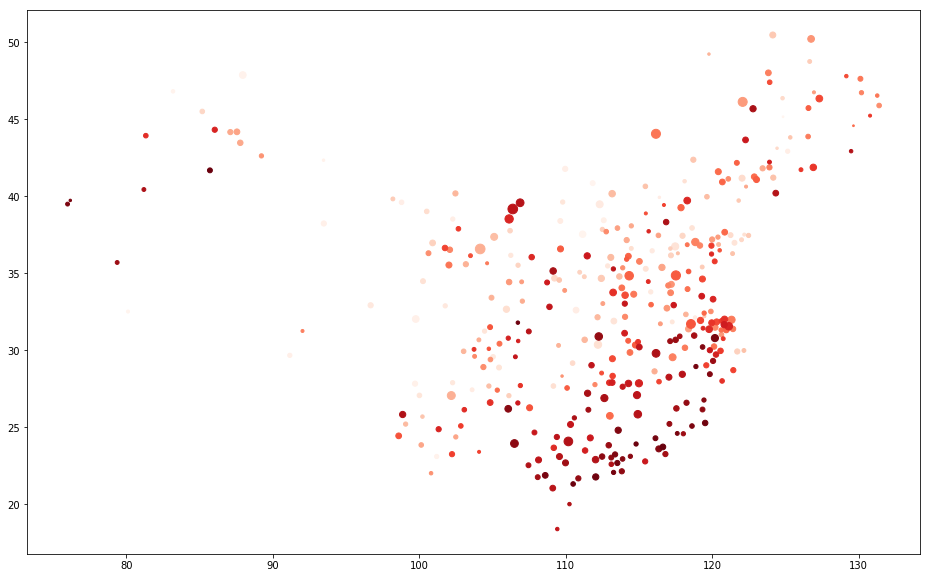

In [7]:
c = sns.color_palette("Reds",len(x))
fig = plt.figure(figsize=(16,10))
plt.scatter(x,y,c=c,s=so2*10)

In [8]:
import arcpy

In [9]:
if arcpy.Exists("work.gdb"):
    pass
else:
    arcpy.CreateFileGDB_management(".","work.gdb")
arcpy.env.workspace = "work.gdb"

In [11]:
feat = "pnt"
projFeat = "pnt_porj"
if arcpy.Exists(feat):
    arcpy.Delete_management(feat)
arcpy.CreateFeatureclass_management(arcpy.env.workspace,feat,"POINT",
                                        spatial_reference=arcpy.SpatialReference(4326))
arcpy.AddField_management(feat,"value","FLOAT")

<Result 'work.gdb\\pnt'>

In [12]:
with arcpy.da.InsertCursor(feat,["SHAPE@XY","value"]) as ins:
    for idx,row in air2.iterrows():
        ins.insertRow(((row["x"],row["y"]),row["PM2.5"]))

In [13]:
if arcpy.Exists(projFeat):
    arcpy.Delete_management(projFeat)

arcpy.Project_management(feat,projFeat,
                                arcpy.SpatialReference(3857))

<Result 'work.gdb\\pnt_porj'>

In [14]:
arcpy.CheckOutExtension("Spatial")
outIDW = arcpy.sa.Idw(projFeat, "value", 10000, 2)

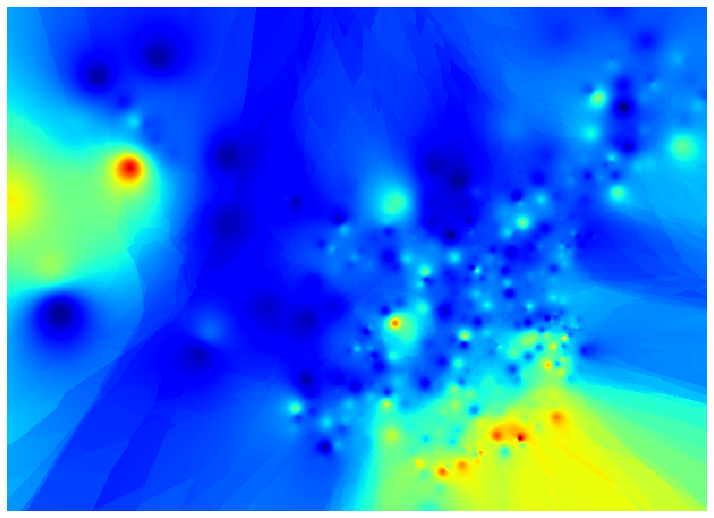

In [15]:
aa = arcpy.RasterToNumPyArray(outIDW)
ax = plt.figure(figsize=(10,7))
plt.axis('off')
plt.imshow(aa,plt.cm.jet)
width = 1024
height = 768
fig.set_size_inches(width/100.0,height/100.0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace =0, wspace =0)
plt.margins(0,0)
plt.savefig("idw.png")

In [16]:
import folium
m = folium.Map([37, 100], zoom_start=4, tiles='OpenStreetMap')
img = folium.raster_layers.ImageOverlay(
        name='时间：{0}'.format(date),
        image="idw.png",
        bounds=[[min(y), min(x)], [max(y), max(x)]],
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1,
    )

folium.Popup('pm2.5').add_to(img)
img.add_to(m)
folium.LayerControl().add_to(m)
m